# RBF Networks 3

In this notebook, unit positioning convergence for RBF networks is investigated and RBFs are used to model ballistical data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(0)
from matplotlib.patches import Circle, Ellipse
from mpl_toolkits.mplot3d import Axes3D

from ann.ballist import ballist_load, \
                        ballist_plot_units, \
                        ballist_gridsearch, \
                        ballist_evaluate
from ann.plotting import figsize, figure, subplots
from ann.rbf_network import *

Using Theano backend.


# Create Input Functions

In [2]:
dataset_sin_clean, dataset_square_clean = create_test_dataset(show=False)
dataset_sin_noisy, dataset_square_noisy = create_test_dataset(noise_variance=0.1, show=False)

# Visualize RBF Positioning Schemes

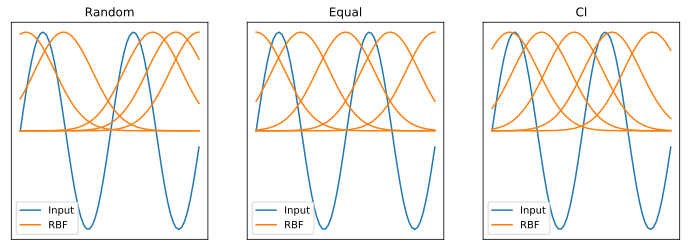

In [22]:
rbf_pos_preview(dataset_sin_clean,
                kwargs_network={'nodes': 5,
                                'node_pos': ['random', 'equal', 'cl'],
                                'cl_learn_cov': False})

plt.savefig('../figures/rbf_node_pos_compare.svg')

# Compare Convergence Speed with and without CL

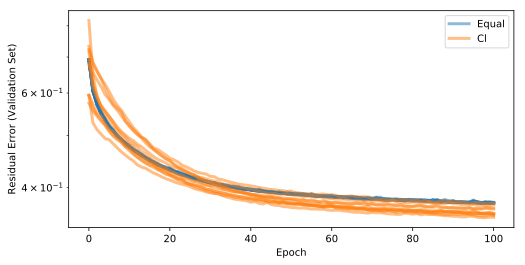

In [4]:
rbf_pos_compare(dataset_sin_clean,
                kwargs_network={'nodes': 18,
                                'node_pos': ['equal', 'cl'],
                                'node_std': 1.3,
                                'cl_learn_cov': False},
                kwargs_training={'learning_rate': 0.1,
                                 'epochs': 100})

plt.savefig('../figures/rbf_equal_cl_compare.svg')

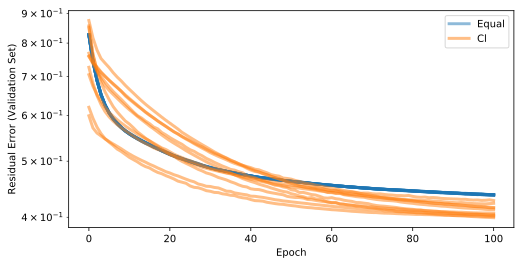

In [5]:
rbf_pos_compare(dataset_sin_noisy,
                kwargs_network={'nodes': 6,
                                'node_pos': ['equal', 'cl'],
                                'node_std': 1.20,
                                'cl_learn_cov': False},
                kwargs_training={'learning_rate': 0.1,
                                 'epochs': 100})

plt.savefig('../figures/rbf_equal_cl_compare.svg')

# Avoid Dead Units

CL summary:

Positions are:
x: -5.000, y: -5.000
x: 5.000, y: 5.000
x: -0.139, y: 0.079

Winnings are:
x: -5.000, y: -5.000 => 0
x: 5.000, y: 5.000 => 0
x: -0.139, y: 0.079 => 10000
CL summary:

Positions are:
x: 0.286, y: 0.849
x: -1.379, y: -0.312
x: 0.617, y: -1.028

Winnings are:
x: 0.286, y: 0.849 => 3329
x: -1.379, y: -0.312 => 3334
x: 0.617, y: -1.028 => 3337


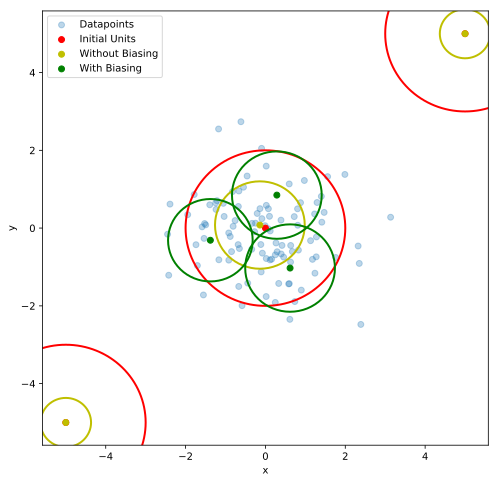

In [19]:
_, ax = subplots(1, 1, size=figsize(2, 2))

def plot_units(mus, covs, color, label=None):
    for i, (mu, cov) in enumerate(zip(mus, covs)):
        ax.scatter(*mu, color=color, label=(label if i == 0 else None))

        c = Circle(mu, radius=np.sqrt(cov[0, 0]), color=color, fill=False, linewidth=2)
        ax.add_artist(c)

# plot datapoints
x, y = np.hsplit(np.random.multivariate_normal((0, 0), np.eye(2), size=(100)), 2)
ax.scatter(x, y, label="Datapoints", alpha=0.3)

# plot initial units
offs = 5
mus = [(-offs, -offs), (offs, offs), (0, 0)]

std = 2
covs = [std * std * np.eye(2)] * len(mus)

plot_units(mus, covs, color='r', label="Initial Units")

# plot final units without biasing
model = GaussianRBFNetwork(domain=np.hstack((x, y)),
                           nodes=len(mus),
                           node_pos='manual')

model.mu = np.array(mus, dtype=float)
model.cov = np.array(covs, dtype=float)

model.init_kernels_cl(std=std,
                      symmetrical=True,
                      random_start=False,
                      learning_rate=0.1,
                      verbose=True)

plot_units(model.mu, model.cov, color='y', label="Without Biasing")

# plot final units with biasing
model.mu = np.array(mus, dtype=float)
model.cov = np.array(covs, dtype=float)

model.init_kernels_cl(std=std,
                      symmetrical=True,
                      random_start=False,
                      learning_rate=0.1,
                      bias=True,
                      bias_weight=0.1,
                      verbose=True)

plot_units(model.mu, model.cov, color='g', label="With Biasing")

# format figure
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.legend()

plt.savefig('../figures/rbf_cl_biasing.svg')

# Approximate Ballistic function

## Load Data

In [3]:
angles, velocities, distances, heights = ballist_load('../data/ballist.dat')

inputs = np.hstack((angles, velocities))

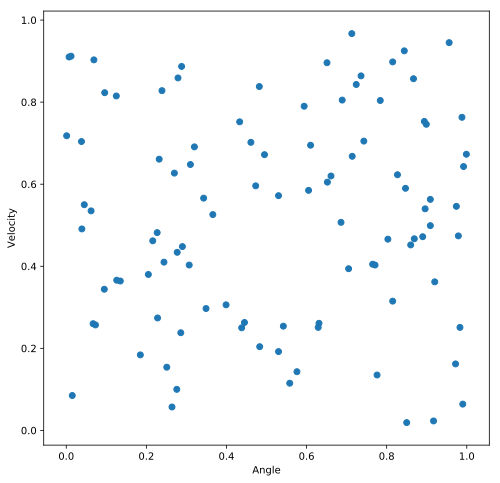

In [4]:
_, ax = subplots(1, 1, size=figsize(2, 2))

ax.scatter(angles, velocities)

ax.set_xlabel("Angle")
ax.set_ylabel("Velocity")

plt.show()

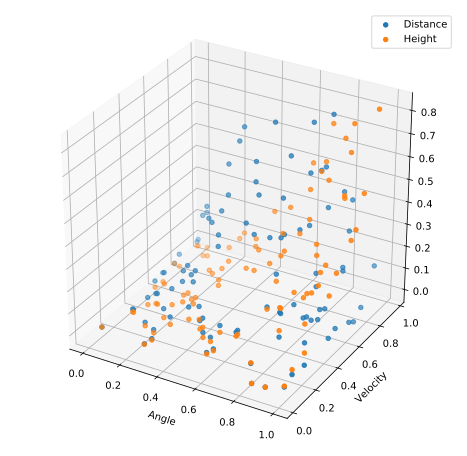

In [5]:
fig = figure(1, 1, size=figsize(2, 2))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(angles, velocities, distances, label="Distance")
ax.scatter(angles, velocities, heights, label="Height")

ax.set_xlabel("Angle")
ax.set_ylabel("Velocity")

ax.legend()

plt.savefig('../figures/ballist_data.svg')

## Preview Unit Placement

In [10]:
model = GaussianRBFNetwork(domain=np.hstack((angles, velocities)),
                           nodes=10,
                           node_pos='cl',
                           node_std=0.2,
                           cl_bias=True,
                           cl_verbose=True)

CL summary:

Positions are:
x: 0.845, y: 0.462
x: 0.136, y: 0.253
x: 0.658, y: 0.867
x: 0.658, y: 0.624
x: 0.092, y: 0.863
x: 0.500, y: 0.228
x: 0.138, y: 0.457
x: 0.931, y: 0.774
x: 0.355, y: 0.644
x: 0.878, y: 0.241

Winnings are:
x: 0.845, y: 0.462 => 1004
x: 0.136, y: 0.253 => 1002
x: 0.658, y: 0.867 => 997
x: 0.658, y: 0.624 => 1000
x: 0.092, y: 0.863 => 1001
x: 0.500, y: 0.228 => 998
x: 0.138, y: 0.457 => 1005
x: 0.931, y: 0.774 => 997
x: 0.355, y: 0.644 => 1001
x: 0.878, y: 0.241 => 995


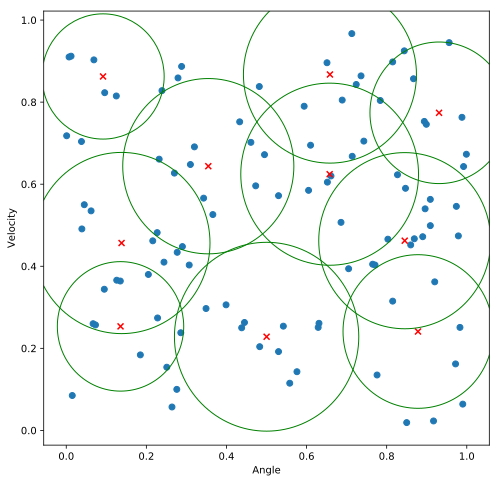

In [11]:
ballist_plot_units(model, angles, velocities)

plt.savefig('../figures/ballist_unit_demo.svg')

## Find Good Model

In [12]:
# shuffle samples
shuffle = np.random.permutation(inputs.shape[0])

inputs_shuffled = inputs[shuffle, :]
distances_shuffled = distances[shuffle, :]
heights_shuffled = heights[shuffle, :]

# split into training and validation data
n_train = int(0.8 * inputs_shuffled.shape[0])

inputs_train, inputs_val = inputs_shuffled[:n_train, :], inputs_shuffled[n_train:, :]
distances_train, distances_val = distances_shuffled[:n_train, :], distances_shuffled[n_train:, :]
heights_train, heights_val = heights_shuffled[:n_train, :], heights_shuffled[n_train:, :]

### Distances

In [11]:
best_model = ballist_gridsearch(inputs_train=inputs_train,
                                outputs_train=distances_train,
                                inputs_val=inputs_val,
                                outputs_val=distances_val,
                                kwargs_network={'nodes': range(2, 31),
                                                'node_pos': 'cl',
                                                'node_std': 0.5,
                                                'cl_symmetrical': [True, False],
                                                'cl_bias': True},
                                kwargs_training={'training': 'least_squares'},
                                verbose=True)

Units          Sigma          Symmetrical    MSE (mean)     MSE (std)
---------------------------------------------------------------------
2              0.50           True           4.27e-02       6.43e-03       
2              0.50           False          4.83e-02       7.17e-03       
3              0.50           True           2.04e-02       8.20e-03       
3              0.50           False          2.16e-02       7.83e-03       
4              0.50           True           1.97e-02       2.11e-03       
4              0.50           False          1.92e-02       4.25e-03       
5              0.50           True           1.31e-02       4.91e-03       
5              0.50           False          1.37e-02       6.26e-03       
6              0.50           True           1.14e-02       1.76e-03       
6              0.50           False          1.26e-02       2.58e-03       
7              0.50           True           7.06e-03       8.74e-04       
7              0.50     

In [6]:
best_model = ballist_gridsearch(inputs_train=inputs_train,
                                outputs_train=distances_train,
                                inputs_val=inputs_val,
                                outputs_val=distances_val,
                                kwargs_network={'nodes': range(31, 51),
                                                'node_pos': 'cl',
                                                'node_std': 0.5,
                                                'cl_symmetrical': True,
                                                'cl_bias': True},
                                kwargs_training={'training': 'least_squares'},
                                verbose=True)

Units          Sigma          Symmetrical    MSE (mean)     MSE (std)
---------------------------------------------------------------------
31             0.50           True           3.00e-05       1.19e-05       
32             0.50           True           3.15e-05       1.45e-05       
33             0.50           True           1.59e-05       1.04e-05       
34             0.50           True           1.91e-05       1.85e-05       
35             0.50           True           1.69e-05       1.42e-05       
36             0.50           True           1.23e-05       1.26e-05       
37             0.50           True           7.53e-06       5.58e-06       
38             0.50           True           1.47e-05       1.13e-05       
39             0.50           True           8.72e-06       7.89e-06       
40             0.50           True           3.77e-06       4.15e-06       
41             0.50           True           2.41e-06       1.96e-06       
42             0.50     

In [7]:
best_model = ballist_gridsearch(inputs_train=inputs_train,
                                outputs_train=distances_train,
                                inputs_val=inputs_val,
                                outputs_val=distances_val,
                                kwargs_network={'nodes': range(40, 61),
                                                'node_pos': 'cl',
                                                'node_std': 0.5,
                                                'cl_symmetrical': True,
                                                'cl_bias': True},
                                kwargs_training={'training': 'least_squares'},
                                runs=100,
                                verbose=True)

Units          Sigma          Symmetrical    MSE (mean)     MSE (std)
---------------------------------------------------------------------
40             0.50           True           4.06e-06       3.95e-06       
41             0.50           True           4.03e-06       3.64e-06       
42             0.50           True           2.69e-06       2.08e-06       
43             0.50           True           2.63e-06       3.20e-06       
44             0.50           True           1.96e-06       1.94e-06       
45             0.50           True           2.14e-06       1.89e-06       
46             0.50           True           2.20e-06       1.40e-06       
47             0.50           True           1.96e-06       1.46e-06       
48             0.50           True           2.06e-06       1.09e-06       
49             0.50           True           2.10e-06       1.21e-06       
50             0.50           True           2.28e-06       1.23e-06       
51             0.50     

In [8]:
best_model = ballist_gridsearch(inputs_train=inputs_train,
                                outputs_train=distances_train,
                                inputs_val=inputs_val,
                                outputs_val=distances_val,
                                kwargs_network={'nodes': 44,
                                                'node_pos': 'cl',
                                                'node_std': np.arange(0.1, 0.6, 0.1),
                                                'cl_symmetrical': True,
                                                'cl_bias': True},
                                kwargs_training={'training': 'least_squares'},
                                runs=100,
                                verbose=True)

Units          Sigma          Symmetrical    MSE (mean)     MSE (std)
---------------------------------------------------------------------
44             0.10           True           1.31e-02       2.47e-03       
44             0.20           True           4.35e-04       2.50e-04       
44             0.30           True           3.29e-05       4.72e-05       
44             0.40           True           4.31e-06       3.59e-06       
44             0.50           True           2.05e-06       1.77e-06       

Best Model:
Nodes: 44
Std: 0.50
Symmetrical: True
MSE: 2.05e-06


In [9]:
best_model = ballist_gridsearch(inputs_train=inputs_train,
                                outputs_train=distances_train,
                                inputs_val=inputs_val,
                                outputs_val=distances_val,
                                kwargs_network={'nodes': 44,
                                                'node_pos': 'cl',
                                                'node_std': np.arange(0.5, 1, 0.1),
                                                'cl_symmetrical': True,
                                                'cl_bias': True},
                                kwargs_training={'training': 'least_squares'},
                                runs=100,
                                verbose=True)

Units          Sigma          Symmetrical    MSE (mean)     MSE (std)
---------------------------------------------------------------------
44             0.50           True           2.31e-06       2.16e-06       
44             0.60           True           1.98e-06       1.69e-06       
44             0.70           True           1.89e-06       2.08e-06       
44             0.80           True           1.83e-06       1.35e-06       
44             0.90           True           1.80e-06       1.62e-06       

Best Model:
Nodes: 44
Std: 0.90
Symmetrical: True
MSE: 1.80e-06


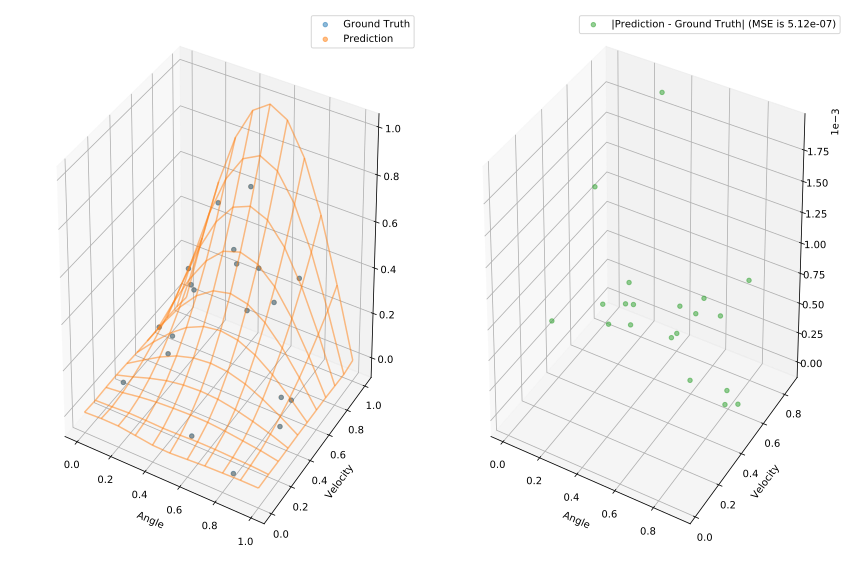

In [13]:
model_distances = GaussianRBFNetwork(domain=inputs,
                                     nodes=44,
                                     node_pos='cl',
                                     node_std=0.9,
                                     cl_symmetrical=True,
                                     cl_bias=True)

model_distances.least_squares_fit(inputs_train, distances_train)

ballist_evaluate(model_distances, inputs_val, distances_val)

plt.tight_layout()

plt.savefig('../figures/ballist_distance_model.svg')

## Heights

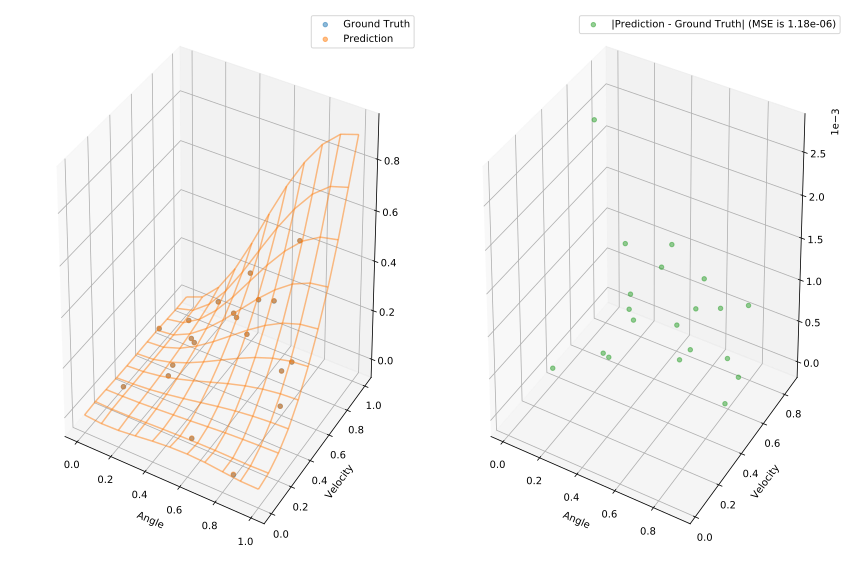

In [14]:
model_heights = model_distances

model_heights.least_squares_fit(inputs_train, heights_train)

ballist_evaluate(model_heights, inputs_val, heights_val)

plt.tight_layout()

plt.savefig('../figures/ballist_heights_model.svg')

## Evaluation

### Units

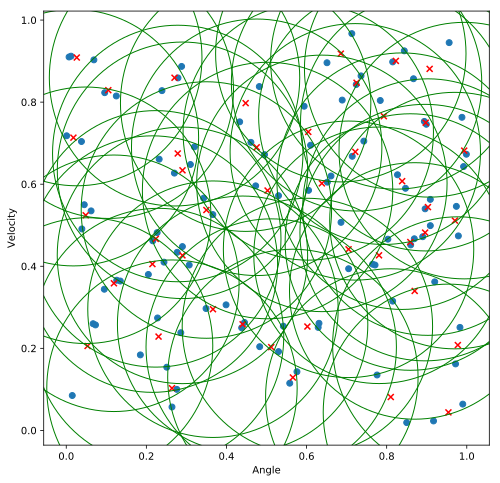

In [15]:
ballist_plot_units(model_distances, angles, velocities)

plt.savefig('../figures/ballist_final_units.svg')

In [16]:
angles_test, velocities_test, distances_test, heights_test = ballist_load('../data/balltest.dat')

inputs_test = np.hstack((angles_test, velocities_test))

### Distances

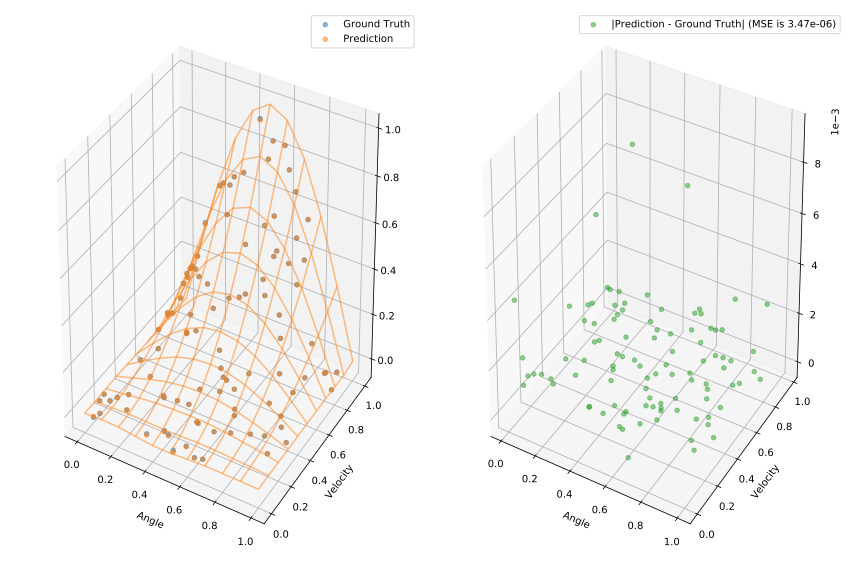

In [17]:
model_distances.least_squares_fit(inputs, distances)

ballist_evaluate(model_distances, inputs_test, distances_test)

plt.tight_layout()

plt.savefig('../figures/ballist_distance_model_eval.svg')

### Heights

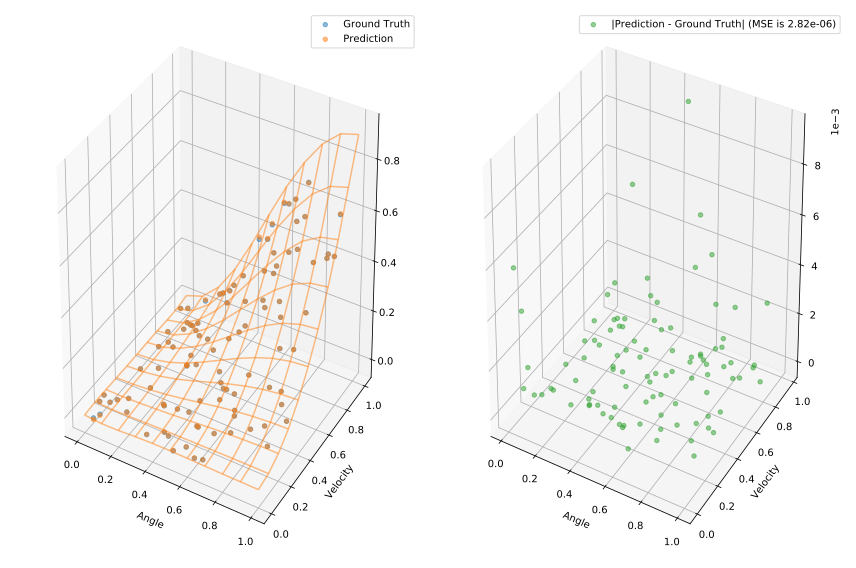

In [18]:
model_heights.least_squares_fit(inputs, heights)

ballist_evaluate(model_heights, inputs_test, heights_test)

plt.tight_layout()

plt.savefig('../figures/ballist_heights_model_eval.svg')